# Step Detection

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import pathlib
import matplotlib.pyplot as pyplot
import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

from scipy import signal
from scipy.fft import fft, fftfreq, rfft, rfftfreq

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
import joblib

from data_processing.config import BOOT_LABEL_FILE, POLE_LABEL_FILE, IMU_DATA_DIR
from data_processing.labels_util import get_labels_data, LabelCol, get_workouts_row_bounds, get_workouts_epoch_bounds, get_workouts_sensor
from data_processing.imu_util import (
    get_sensor_file, ImuCol, load_imu_data, Sensor, fix_epoch, resample_uniformly, time_to_row_range, get_data_chunk,
    normalize_with_bounds, data_to_features
)
from data_processing.data_util import find_nearest, find_nearest_index, shift, low_pass_filter
from data_processing.enums import Activity
from visualization.visualize import multiplot

# import data types
from pandas import DataFrame
from numpy import ndarray
from typing import List, Tuple, Optional

## Pre-processing

### Load IMU data and labels
We want the IMU data for each workout that we have labels for.

In [2]:
# CHANGE THIS
labels: ndarray = get_labels_data(BOOT_LABEL_FILE, Activity.Boot)
#labels = get_labels_data(POLE_LABEL_FILE, Activity.Pole)

# Get workout metrics
all_workout_rows: List[Tuple[int, int]] = get_workouts_row_bounds(labels)
all_workout_times: List[Tuple[int, int]] = get_workouts_epoch_bounds(labels)
all_workout_sensors: List[str] = get_workouts_sensor(labels)
all_workout_unpadded: List[Tuple[int, int]] = []
num_workouts = len(all_workout_rows)

# Get IMU data and step labels for each workout
all_workout_data: List[ndarray] = [] # uncleaned IMU data
all_workout_labels: List[ndarray] = []
    
for i in range(num_workouts):
    start_row, end_row = all_workout_rows[i] # rows in label data
    start_time, end_time = all_workout_times[i]
    sensor: str = all_workout_sensors[i]
    
    # get IMU data
    imu_data: ndarray = load_imu_data(get_sensor_file(sensor_name = sensor, sensor_type=Sensor.Accelerometer))
    data_start, data_end = time_to_row_range(imu_data, start_time, end_time, expected_range=3*60, expected_range_error=10)
    imu_data, unpadded_bounds = get_data_chunk(imu_data, data_start, data_end, 50) # padded data
    
    all_workout_data.append(imu_data)
    all_workout_unpadded.append(unpadded_bounds)
    
    # get step labels data
    all_workout_labels.append(labels[start_row:end_row+1, :])

Check that we extracted the workouts correctly.

<IPython.core.display.Javascript object>


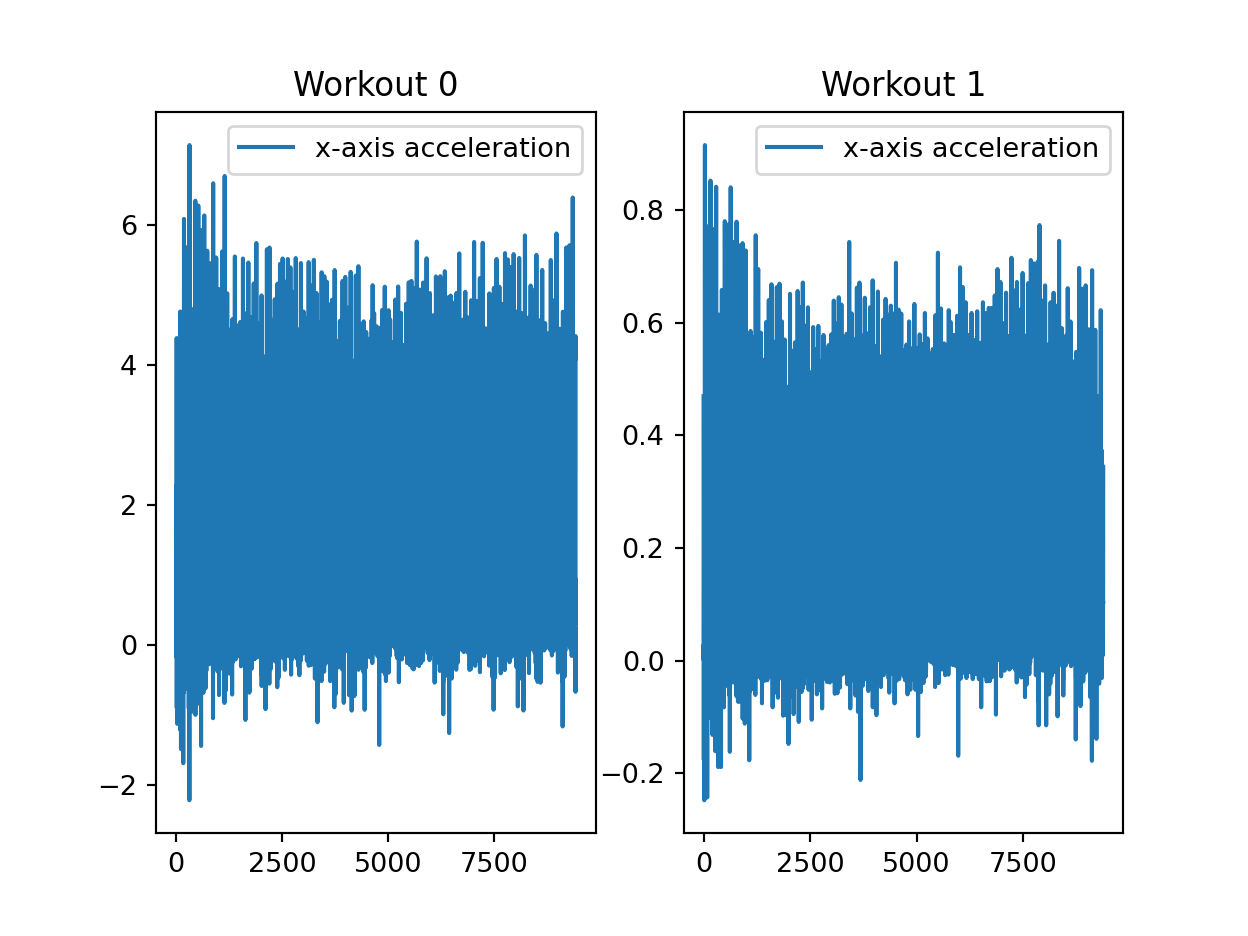

In [3]:
def plot_helper(workout_idx, plot):
    plot.plot(all_workout_data[workout_idx][:, ImuCol.XACCEL], label = "x-axis acceleration")
    plot.set_title('Workout %d' % workout_idx)
    plot.legend()

multiplot(num_workouts, plot_helper)

### Clean IMU data
We will need to pre-process the IMU data to
* <u>**TODO**</u> check if sensor was inverted somehow...
* **Fix unusual epoch times**. See [Workout Detection](workout-detection.ipynb) notebook for more details.
* **Resample data uniformly**. See [Workout Detection](workout-detection.ipynb) notebook for more details.
* **Normalize** acceleration.
* <u>**TODO**</u> This is probably not crucial for now. Remove outliers with huge max acceleration values. An outlier would ruin the accuracy of the model.

In [4]:
all_data_point_ids: List[ndarray] = []
all_clean_workout_data: List[ndarray] = []
    
for i in range(num_workouts):
    data: ndarray = all_workout_data[i]
    unpadded_bounds = all_workout_unpadded[i]
        
    # save old timestamp values that identify a data point (labels map to these values)
    all_data_point_ids.append(data[:, ImuCol.TIME].astype(int))
    
    # normalize
    data[:, ImuCol.XACCEL] = normalize_with_bounds(data[:, ImuCol.XACCEL], unpadded_bounds[0], unpadded_bounds[1])
    data[:, ImuCol.YACCEL] = normalize_with_bounds(data[:, ImuCol.YACCEL], unpadded_bounds[0], unpadded_bounds[1])
    data[:, ImuCol.ZACCEL] = normalize_with_bounds(data[:, ImuCol.ZACCEL], unpadded_bounds[0], unpadded_bounds[1])
    
    # pre-process
    data[:] = fix_epoch(data)
    clean_data = resample_uniformly(data)
    
    # save clean data
    all_clean_workout_data.append(clean_data)

Compare data before and after resampling. Should be similar

<IPython.core.display.Javascript object>


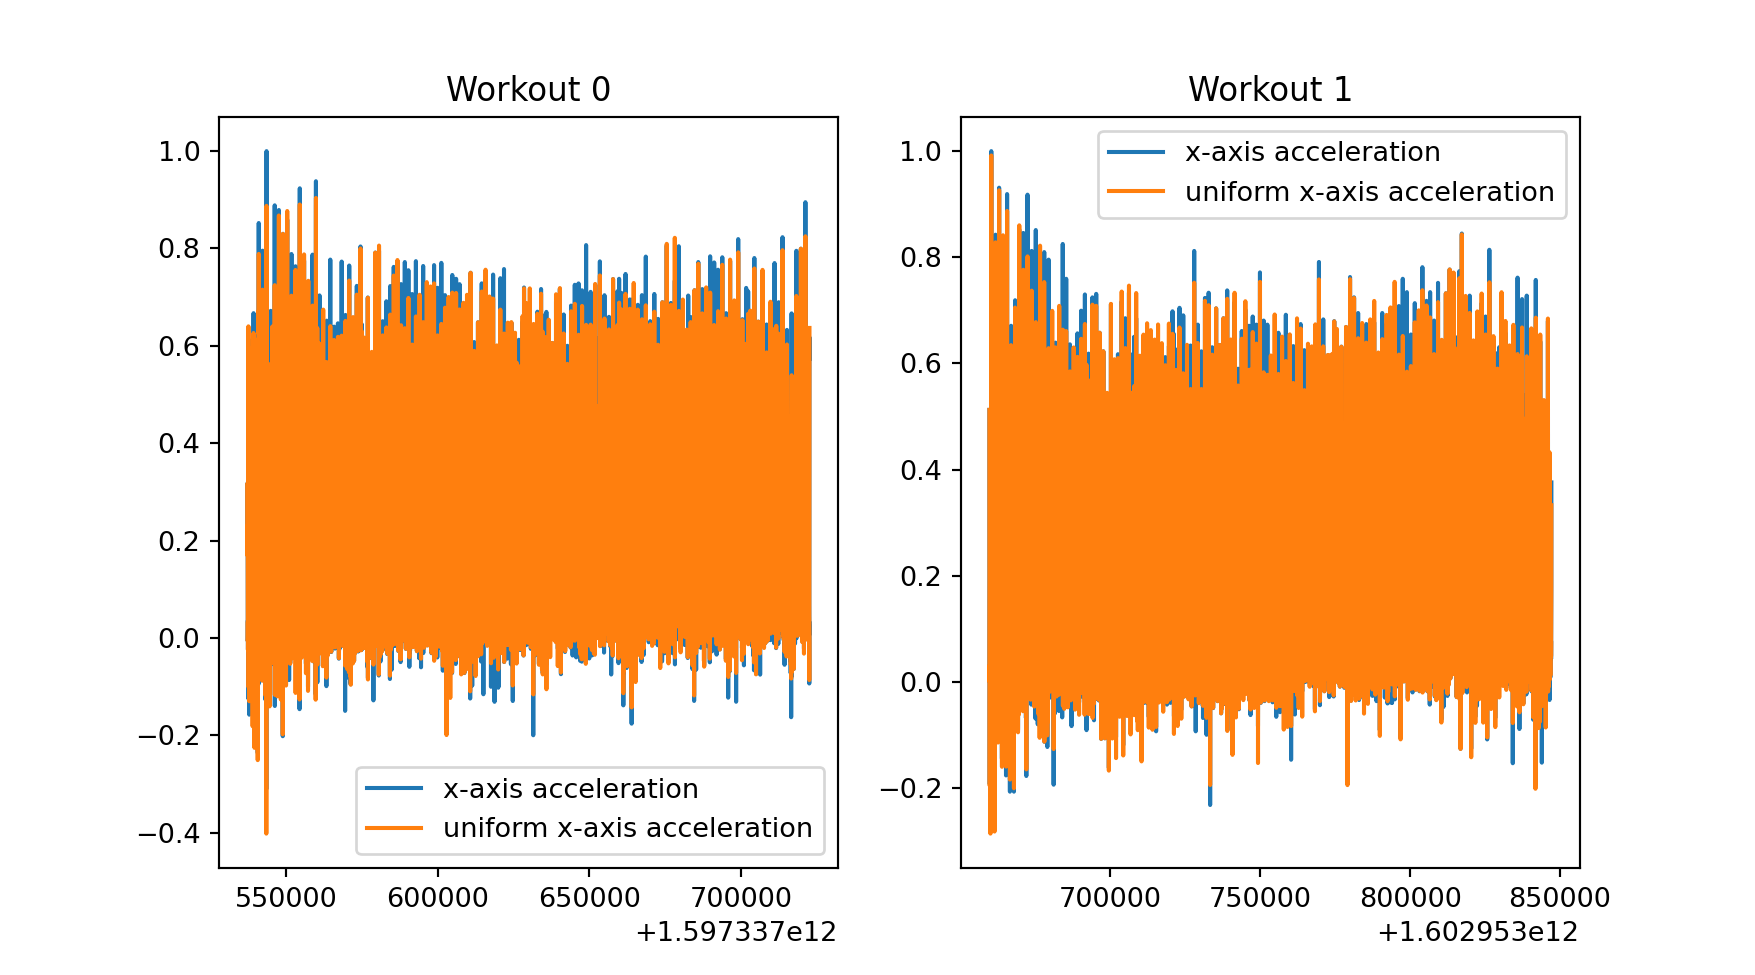

In [5]:
def plot_helper(workout_idx, plot):
    pre_resample = all_workout_data[workout_idx]
    post_resample = all_clean_workout_data[workout_idx]
    plot.plot(pre_resample[:, ImuCol.TIME], pre_resample[:, ImuCol.XACCEL], label = "x-axis acceleration")
    plot.plot(post_resample[:, ImuCol.TIME], post_resample[:, ImuCol.XACCEL], label = "uniform x-axis acceleration")
    plot.set_title('Workout %d' % workout_idx)
    plot.legend()
    
multiplot(num_workouts, plot_helper)

### Reduce signal noise
Apply a low-pass filter with a cut-off of 10Hz.

<IPython.core.display.Javascript object>


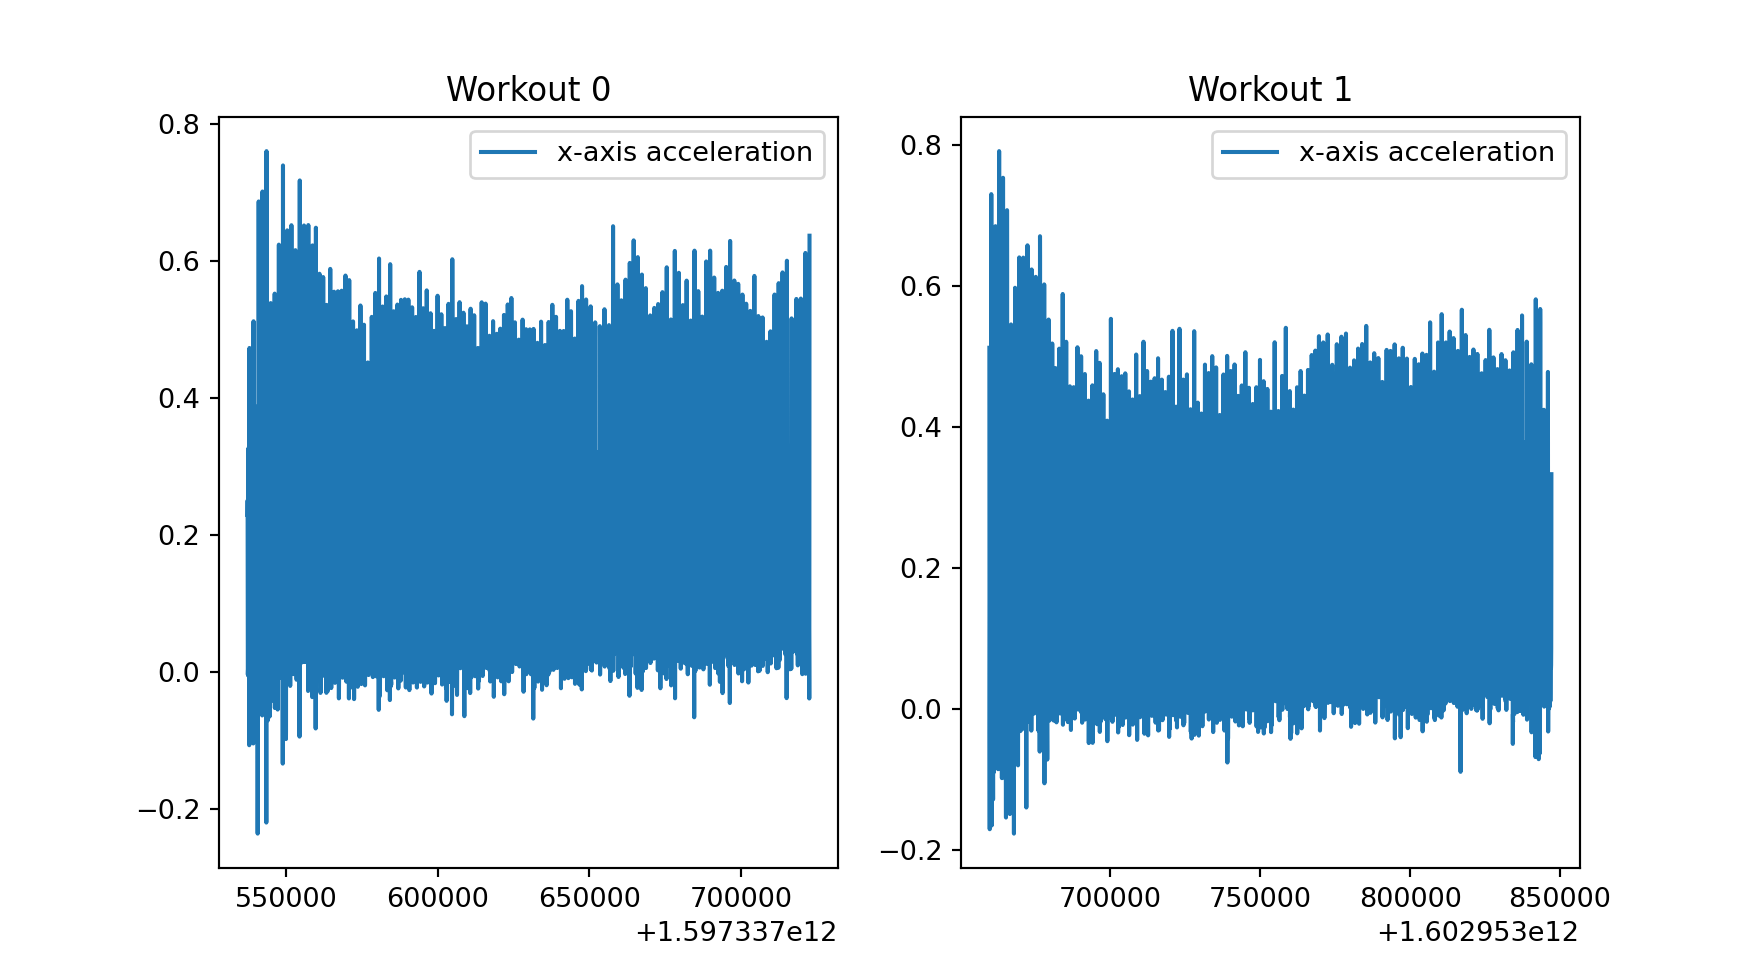

In [6]:
   
for i in range(num_workouts):
    clean_imu_data = all_clean_workout_data[i]
    clean_imu_data[:, ImuCol.XACCEL] = low_pass_filter(clean_imu_data[:, ImuCol.XACCEL])
    clean_imu_data[:, ImuCol.YACCEL] = low_pass_filter(clean_imu_data[:, ImuCol.YACCEL])
    clean_imu_data[:, ImuCol.ZACCEL] = low_pass_filter(clean_imu_data[:, ImuCol.ZACCEL])

# Plot
def plot_helper(idx, plot):
    clean_imu_data = all_clean_workout_data[idx]
    plot.plot(clean_imu_data[:, ImuCol.TIME], clean_imu_data[:, ImuCol.XACCEL], label = "x-axis acceleration")
    plot.set_title('Workout %d' % idx)
    plot.legend()
    
multiplot(num_workouts, plot_helper)

## Gradient Boosting Machine (GBM)
Build a GBM model for step detection

### Pre-process for model
#### Create labeled data for model
Label IMU data points within a step as "steps" and other points as "non-steps".

In [7]:
all_model_labels: List[Optional[ndarray]] = []
all_old_label_times: List[Optional[ndarray]] = []
all_failures: List[List[Tuple[int, int]]] = [] # for each workout, list all row ranges that have bad data
    
for i in range(num_workouts):
    orig_data: ndarray = all_workout_data[i]
    data_point_ids: ndarray = all_data_point_ids[i]
    clean_data: ndarray = all_clean_workout_data[i]
    step_labels: ndarray = all_workout_labels[i]
    
    # 1: data point is within a step
    # 0: data point is outside all steps
    model_labels = np.zeros((clean_data.shape[0],), dtype=int)
    
    # store old start/end times
    old_labels = np.zeros((step_labels.shape[0], 2), dtype=int)
    
    # Label data points as steps or non-steps
    failed_steps: List[int] = [] # index to all steps that failed
    num_steps: int = step_labels.shape[0]
        
    def get_start_end_indices(step_idx):
        """Index to original IMU data (before resampling)"""
        return (np.where(data_point_ids == step_labels[step_idx, LabelCol.START])[0],
                np.where(data_point_ids == step_labels[step_idx, LabelCol.END])[0])
        
    for j in range(num_steps): # iterate each "step"
        # find start/end row indices in original IMU data (before resampling)
        start_indices, end_indices = get_start_end_indices(j)
        if len(start_indices) != 1 or len(end_indices) != 1:
            # None found or duplicates found. Skip...
            failed_steps.append(j)
            continue
        start_row_orig: int = start_indices[0]
        end_row_orig: int = end_indices[0]

        # find start/end rows in cleaned data
        start_time, end_time = orig_data[start_row_orig, ImuCol.TIME], orig_data[end_row_orig, ImuCol.TIME]
        start_row_new = find_nearest_index(clean_data[:, ImuCol.TIME], start_time)
        end_row_new = find_nearest_index(clean_data[:, ImuCol.TIME], end_time)
        
        # update labels with start/end times that match data points in the cleaned data
        step_labels[j, LabelCol.START] = clean_data[start_row_new, ImuCol.TIME]
        step_labels[j, LabelCol.END] = clean_data[end_row_new, ImuCol.TIME]
        
        # save start/end times in original IMU data (before resampling)
        old_labels[j,0] = orig_data[start_row_orig, ImuCol.TIME]
        old_labels[j,1] = orig_data[end_row_orig, ImuCol.TIME]
        
        # label step data points as 1
        model_labels[start_row_new:end_row_new+1] = 1

    # Record failures
    failure_ranges: List[Tuple[int, int]] = []
    if len(failed_steps) > 0:
        success_steps = np.delete(np.arange(num_steps), failed_steps)
        for j in failed_steps:
            # Get neighboring success steps
            prev_step: Optional[int] = None
            next_step: Optional[int] = None
            _nearest_index = find_nearest_index(success_steps, j)
            nearest_step = success_steps[_nearest_index]
            if nearest_step > j:
                if _nearest_index-1 >= 0:
                    prev_step = success_steps[_nearest_index-1] if _nearest_index-1 >= 0 else None
                next_step = nearest_step
            else:
                if _nearest_index+1 < len(success_steps):
                    next_step = success_steps[_nearest_index+1] if _nearest_index+1 < num_steps else None
                prev_step = nearest_step

            # Get first failure row
            fail_first_row: int                
            if prev_step is None:
                fail_first_row = 0
            else:
                _indexes = np.where(clean_data[:, ImuCol.TIME] == step_labels[prev_step, LabelCol.END])[0]
                if len(_indexes) != 1:
                    raise Exception('Something went horribly wrong.')
                fail_first_row = _indexes[0] + 1
            
            # Get last failure row
            fail_last_row: int
            if next_step is None:
                fail_last_row = clean_data.shape[0] - 1
            else:
                _indexes = np.where(clean_data[:, ImuCol.TIME] == step_labels[next_step, LabelCol.START])[0]
                if len(_indexes) != 1:
                    raise Exception('Something went horribly wrong.')
                fail_last_row = _indexes[0] - 1
                
            failure_ranges.append((fail_first_row, fail_last_row))                
                # Attempt at fixing the error cases. Doesn't fix all...
#                 # this step must be in the following time bounds
#                 prev_time = old_labels[prev_step, 1] if prev_step is not None else old_labels.min() - 1
#                 next_time = old_labels[next_step, 0] if next_step is not None else old_labels.max() + 1
#                 print('bounds', prev_time, next_time)
                
#                 start_indices, end_indices = get_start_end_indices(j)
#                 start_times, end_times = orig_data[start_indices, ImuCol.TIME], orig_data[end_indices, ImuCol.TIME]
                
#                 print('start', start_times.astype(int))
#                 print('end', end_times.astype(int))
                
#                 if len(start_times) == 0 or len(end_indices) == 0:
#                     raise Exception('ERROR: Label does not map to a data point')
                
#                 # keep times between prev and next steps
#                 if len(start_times) > 1:
#                     start_times = orig_data[start_indices, ImuCol.TIME]
#                     filt = np.where((start_times > prev_time) & (start_times < next_time))[0]
#                     start_times = start_times[filt]
#                     start_indices = start_indices[filt]
#                 if len(end_times) > 1:
#                     end_times = orig_data[end_indices, ImuCol.TIME]
#                     filt = np.where((end_times > prev_time) & (end_times < next_time))[0]
#                     end_times = end_times[filt]
#                     end_indices = end_indices[filt]
                        
#                 # make sure start times isn't larger than all end times. Same vice versa
#                 if len(start_times) > 1:
#                     filt = np.where(start_times < orig_data[end_indices[0], ImuCol.TIME])[0]
#                     start_times = start_times[filt]
#                     start_indices = start_indices[filt]
#                 if len(end_times) > 1:
#                     filt = np.where(end_times > orig_data[start_indices[0], ImuCol.TIME])[0]
#                     end_times = end_times[filt]
#                     end_indices = end_indices[filt]
                    
#                 print('start', start_times.astype(int))
#                 print('end', end_times.astype(int))
                    
#                 # has problem been fixed?
#                 if len(start_times) != 1:
#                     raise Exception('ERROR: Failed to fix the label')
#                 if len(end_times) != 1:
#                     raise Exception('ERROR: Failed to fix the label')
                        

#         except Exception as e:
#             print(str(e))
#             print('Not all labels for workout %d could be mapped. Skipping workout...' % i)
#             all_model_labels.append(None)
#             all_old_label_times.append(None)
#             continue

    all_model_labels.append(model_labels)
    all_old_label_times.append(old_labels)
    all_failures.append(failure_ranges)

Check if labels mapped to the cleaned data are still accurate

<IPython.core.display.Javascript object>


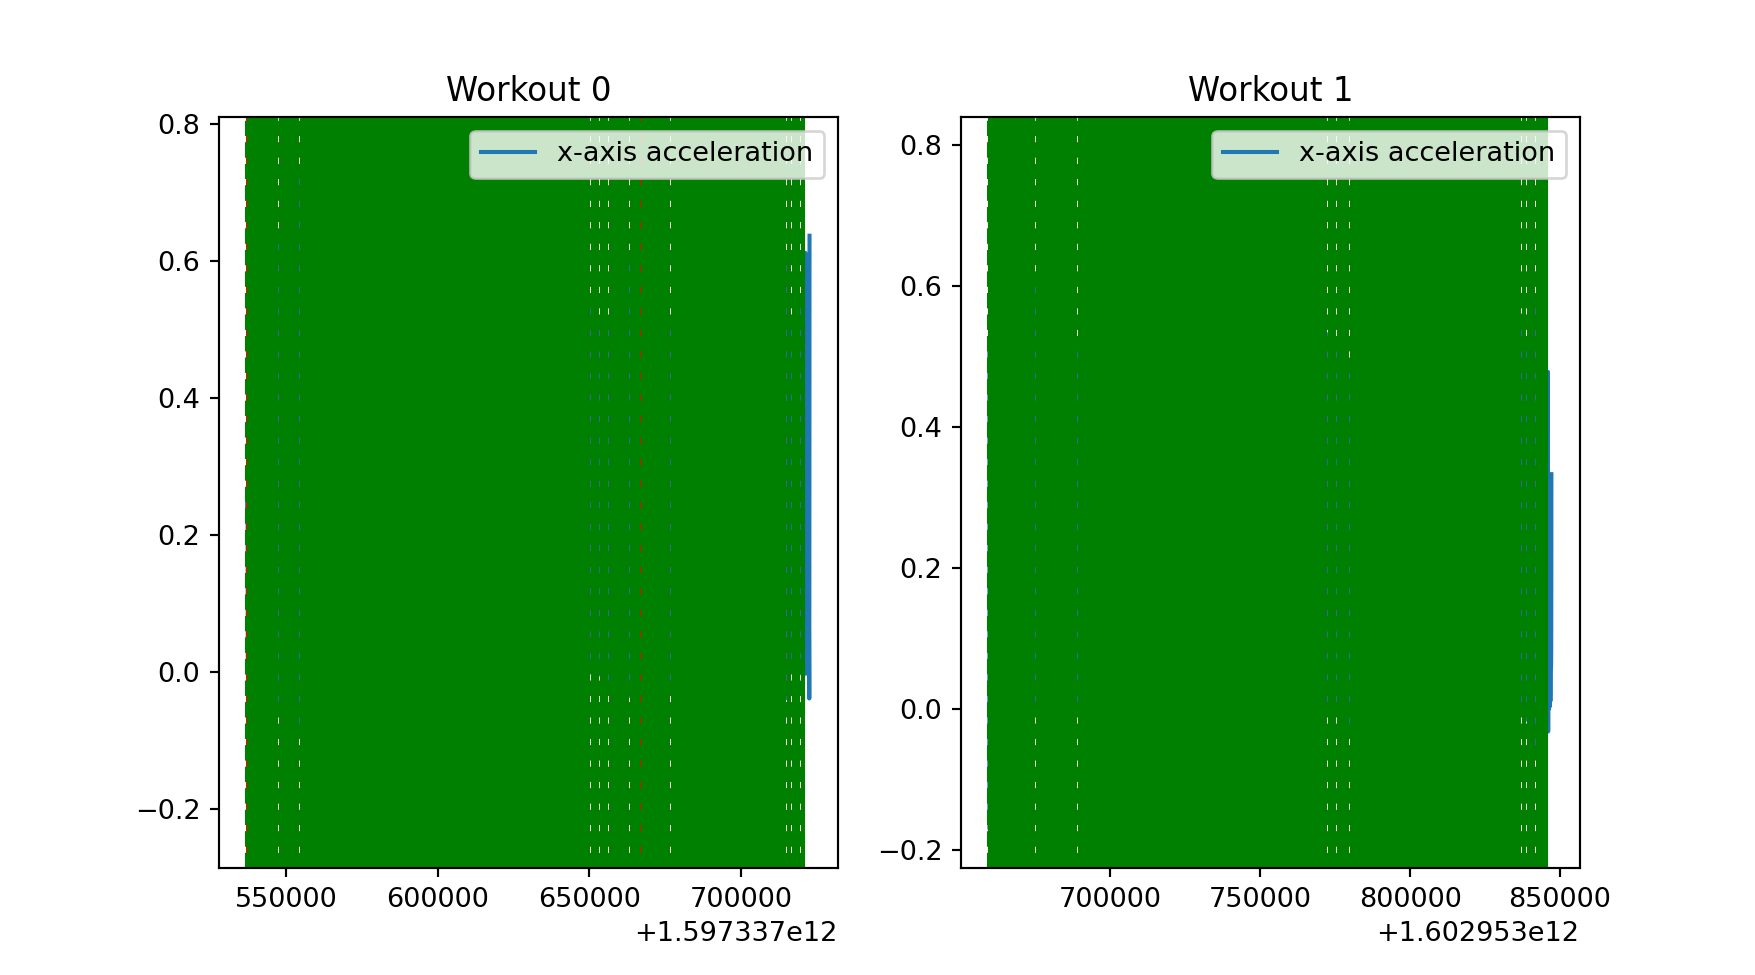

In [8]:
def plot_helper(workout_idx, plot):
    data = all_clean_workout_data[workout_idx]
    old_labels = all_old_label_times[workout_idx]
    step_labels = all_workout_labels[workout_idx]
    
    min_x = data[0, ImuCol.TIME]
    max_x = data[-1, ImuCol.TIME]
    def is_in_bounds(x: int):
        return x >= min_x and x <= max_x
    
    plot.plot(data[:, ImuCol.TIME], data[:, ImuCol.XACCEL], label = "x-axis acceleration")
    # plot old lines
    for i in range(old_labels.shape[0]):
        if not is_in_bounds(old_labels[i, 0]) or not is_in_bounds(old_labels[i, 1]):
            continue
        plot.axvline(x=old_labels[i, 0], linestyle='dashed', color='red')
        plot.axvline(x=old_labels[i, 1], linestyle='solid', color='red')
    # plot new lines
    for i in range(step_labels.shape[0]):
        if not is_in_bounds(step_labels[i, LabelCol.START]) or not is_in_bounds(step_labels[i, LabelCol.END]):
            continue
        plot.axvline(x=step_labels[i, LabelCol.START], linestyle='dashed', color='green')
        plot.axvline(x=step_labels[i, LabelCol.END], linestyle='solid', color='green')
    plot.set_title('Workout %d' % workout_idx)
    plot.legend()
    
multiplot(num_workouts, plot_helper)

Check if the labeled data for GBM is correct

In [9]:
# Uncomment to run. This code is very time consuming

# def plot_helper(workout_idx, plot):
#     data = all_clean_workout_data[workout_idx]
#     step_labels = all_workout_labels[workout_idx]
#     model_labels = all_model_labels[workout_idx]
    
#     min_x = data[0, ImuCol.TIME]
#     max_x = data[-1, ImuCol.TIME]
#     def is_in_bounds(x: int):
#         return x >= min_x and x <= max_x
    
#     plot.plot(data[:, ImuCol.TIME], data[:, ImuCol.XACCEL], label = "x-axis acceleration")
    
#     # shade steps
#     for i in range(model_labels.shape[0]):
#         if model_labels[i] == 1:
#             plot.axvline(x=data[i, ImuCol.TIME], linestyle='dotted', color='red')
            
#     # plot new lines
#     for i in range(step_labels.shape[0]):
#         if not is_in_bounds(step_labels[i, LabelCol.START]) or not is_in_bounds(step_labels[i, LabelCol.END]):
#             continue
#         plot.axvline(x=step_labels[i, LabelCol.START], linestyle='dashed', color='green')
#         plot.axvline(x=step_labels[i, LabelCol.END], linestyle='solid', color='green')
#     plot.set_title('Workout %d' % workout_idx)
#     plot.legend()
    
# multiplot(num_workouts, plot_helper)

#### Create feature data for model

In [10]:
all_model_data: List[ndarray] = []

for i in range(num_workouts):
    data = all_clean_workout_data[i]
    model_data = data_to_features(data)
    all_model_data.append(model_data)

#### Remove excess or erroneous data points
* Excess data points: we previously added some buffer data before and after each workout. Now we remove this excess data.
* Erroneous data points: some "ski step" labels failed to map to the IMU data.

In [11]:
for i in range(num_workouts):
    model_data = all_model_data[i]
    model_labels = all_model_labels[i]
    failure_ranges = all_failures[i]
    
    # Array to indicate data to delete
    to_keep: ndarray = np.ones(model_labels.shape, dtype=bool) # init to True
    
    # Remove datapoints before first step and after last step
    steps_idx = np.where(model_labels == 1)[0]
    if len(steps_idx) == 0:
        print('Something is wrong with the labeled data for workout %d...' % i)
        continue
    start, end = steps_idx[0], steps_idx[-1]
    to_keep[:start] =  False
    to_keep[end+1:] = False
        
    # Remove failure data points
    for (start, end) in failure_ranges:
        to_keep[start:end+1] = False
    
    # Commit removal
    all_model_data[i] = model_data[to_keep, :]
    all_model_labels[i] = model_labels[to_keep]

#### Join data for all workouts

In [12]:
full_model_data: ndarray = np.empty((0, model_data.shape[1]), dtype=np.float64)
full_model_labels: ndarray = np.empty(0, dtype=int)

for i in range(num_workouts):
    model_data = all_model_data[i]
    model_labels = all_model_labels[i]
        
    full_model_data = np.append(full_model_data, model_data, axis=0)
    full_model_labels = np.append(full_model_labels, model_labels, axis=0)
    
print(full_model_data.shape)
print(full_model_labels.shape)

(18451, 52)
(18451,)


Now we finally have our labeled data set ready for building our model!

### Train GBM model

In [13]:
# Evaluate model accuracy using k-fold cross-validation
# This is time consuming, uncomment to use.

# print('Evaluating model accuracy...')
# model = GradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
# n_scores = cross_val_score(model, full_model_data, full_model_labels, scoring='accuracy', cv=cv, n_jobs=-1)
# print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [14]:
# Fit the model on the whole dataset
# This is time consuming, uncomment to use

# print('Fitting model...')
# model = GradientBoostingClassifier()
# model.fit(full_model_data, full_model_labels)
# print('Done')

## Save models

In [15]:
# Once a new model is confirmed ready for production, move these to the "models" folder

#joblib.dump(model, 'gbm-boot-model.pkl')
#joblib.dump(model, 'gbm-pole-model.pkl')